In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = '/path'
if not os.path.exists(datadir):
  !ln -s '/path' $datadir
os.chdir(datadir)
!pwd

# Data Setup

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random


def rotate_img(img, rot):
    if rot == 0: # 0 degrees rotation
        return img
    elif rot == 1:
      return transforms.functional.rotate(img, 90)
    elif rot == 2:
      return transforms.functional.rotate(img, 180)
    elif rot == 3:
      return transforms.functional.rotate(img, 270)
    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')


class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..1.0].


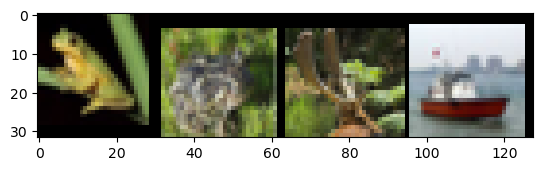

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..1.0].


Class labels:  frog  frog  deer  ship 


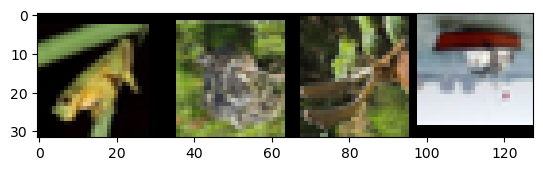

Rotation labels:  90    90    90    180  


In [ ]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

# Evaluation code

In [ ]:
import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)

            # The class with the highest energy is what we choose as prediction
            outputs = net(images)

            # Get predicted class labels
            predictions = outputs.argmax(dim=1)

            # Update correct and total predictions
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            # Loss
            avg_test_loss += criterion(outputs, labels)  / len(testloader)

    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

    return 100 * correct / total

In [ ]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

## 1. Train a ResNet18 on the rotation task

In this section, we will train a ResNet18 model on the rotation task. The input is a rotated image and the model predicts the rotation label.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=4)
net = net.to(device)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [ ]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task, trainloader, testloader):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            # Set the data to the correct device; Different task will use different inputs and labels
            if task == 'rotation':
              images, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
              images, labels = imgs.to(device), cls_label.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Get predicted results
            predicted = outputs.argmax(dim=1)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # Run the run_test() function after each epoch; Set the model to the evaluation mode.
        net.eval()
        test_acc = run_test(net, testloader, criterion, task)

    print('Finished Training')
    return test_acc

In [ ]:
_ = train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.01,
          task='rotation', trainloader=trainloader, testloader=testloader)

# Save the model
PATH = './cifar_rotation_net.pth'
torch.save(net.state_dict(), PATH)

[1,   100] loss: 1.585 acc: 31.71 time: 2.44
[1,   200] loss: 1.284 acc: 43.71 time: 2.07
[1,   300] loss: 1.215 acc: 46.44 time: 2.04
TESTING:
Accuracy of the network on the 10000 test images: 51.55 %
Average loss on the 10000 test images: 1.094
[2,   100] loss: 1.120 acc: 51.03 time: 2.12
[2,   200] loss: 1.103 acc: 52.02 time: 2.03
[2,   300] loss: 1.086 acc: 53.14 time: 2.20
TESTING:
Accuracy of the network on the 10000 test images: 57.15 %
Average loss on the 10000 test images: 1.025
[3,   100] loss: 1.047 acc: 55.43 time: 2.14
[3,   200] loss: 1.048 acc: 55.48 time: 2.05
[3,   300] loss: 1.022 acc: 56.76 time: 2.05
TESTING:
Accuracy of the network on the 10000 test images: 58.58 %
Average loss on the 10000 test images: 0.977
[4,   100] loss: 1.005 acc: 57.56 time: 2.15
[4,   200] loss: 0.990 acc: 58.30 time: 2.07
[4,   300] loss: 0.975 acc: 58.41 time: 2.07
TESTING:
Accuracy of the network on the 10000 test images: 60.34 %
Average loss on the 10000 test images: 0.944
[5,   100] l

## 2.1 Fine-tuning on the pre-trained model

In this section, we will load the pre-trained ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# Load the pre-trained ResNet18 model
net2 = resnet18(num_classes=4)
net2.load_state_dict(torch.load('./cifar_rotation_net.pth'))

# Change output layer to match new number of classes (10)
net2.fc = nn.Linear(net2.fc.in_features, 10)
net2 = net2.to(device)

/tmp/ipykernel_3180069/2601131149.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net2.load_state_dict(torch.load('./cifar_rotation_net.pth'))


In [ ]:
next(net2.parameters()).device

device(type='cuda', index=0)

In [ ]:
# Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
for name, param in net2.named_parameters():
    if not name.startswith('layer4') and not name.startswith('fc'):
        param.requires_grad = False

In [ ]:
# Print all the trainable parameters
params_to_update = net2.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net2.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [ ]:
# Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net2.parameters()) # lr=0.001

In [ ]:
_ = train(net2, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01,
          task='classification', trainloader=trainloader, testloader=testloader)

[1,   100] loss: 1.771 acc: 34.98 time: 2.17
[1,   200] loss: 1.488 acc: 45.85 time: 2.08
[1,   300] loss: 1.420 acc: 47.89 time: 2.07
TESTING:
Accuracy of the network on the 10000 test images: 50.39 %
Average loss on the 10000 test images: 1.372
[2,   100] loss: 1.361 acc: 50.98 time: 2.18
[2,   200] loss: 1.355 acc: 51.06 time: 2.08
[2,   300] loss: 1.336 acc: 51.49 time: 2.08
TESTING:
Accuracy of the network on the 10000 test images: 54.36 %
Average loss on the 10000 test images: 1.276
[3,   100] loss: 1.318 acc: 52.35 time: 2.17
[3,   200] loss: 1.304 acc: 52.58 time: 2.07
[3,   300] loss: 1.308 acc: 52.53 time: 2.06
TESTING:
Accuracy of the network on the 10000 test images: 55.80 %
Average loss on the 10000 test images: 1.249
[4,   100] loss: 1.272 acc: 54.05 time: 2.19
[4,   200] loss: 1.259 acc: 54.70 time: 2.07
[4,   300] loss: 1.270 acc: 54.16 time: 2.07
TESTING:
Accuracy of the network on the 10000 test images: 56.63 %
Average loss on the 10000 test images: 1.225
[5,   100] l

In [ ]:
# Save the model
PATH = './cifar_classification21_net.pth'
torch.save(net2.state_dict(), PATH)

## 2.2 Fine-tuning on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# Randomly initialize a ResNet18 model
net3 = resnet18(num_classes=10)
net3 = net3.to(device)

In [ ]:
# Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
# To do this, you should set requires_grad=False for the frozen layers.
for name, param in net3.named_parameters():
    if not name.startswith('layer4') and not name.startswith('fc'):
        param.requires_grad = False

In [ ]:
# Print all the trainable parameters
params_to_update = net3.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net3.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [ ]:
# Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net3.parameters())

In [ ]:
_ = train(net3, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification', trainloader=trainloader, testloader=testloader)


[1,   100] loss: 2.241 acc: 24.52 time: 2.12
[1,   200] loss: 1.976 acc: 29.61 time: 2.05
[1,   300] loss: 1.896 acc: 31.57 time: 2.05
TESTING:
Accuracy of the network on the 10000 test images: 36.25 %
Average loss on the 10000 test images: 1.785
[2,   100] loss: 1.838 acc: 33.55 time: 2.14
[2,   200] loss: 1.822 acc: 33.62 time: 2.08
[2,   300] loss: 1.792 acc: 35.05 time: 2.05
TESTING:
Accuracy of the network on the 10000 test images: 38.51 %
Average loss on the 10000 test images: 1.696
[3,   100] loss: 1.766 acc: 35.38 time: 2.15
[3,   200] loss: 1.771 acc: 35.99 time: 2.05
[3,   300] loss: 1.774 acc: 36.02 time: 2.06
TESTING:
Accuracy of the network on the 10000 test images: 38.78 %
Average loss on the 10000 test images: 1.688
[4,   100] loss: 1.758 acc: 35.66 time: 2.15
[4,   200] loss: 1.753 acc: 36.45 time: 2.06
[4,   300] loss: 1.729 acc: 37.52 time: 2.05
TESTING:
Accuracy of the network on the 10000 test images: 40.02 %
Average loss on the 10000 test images: 1.670
[5,   100] l

In [ ]:
PATH = './cifar_classification22_net.pth'
torch.save(net3.state_dict(), PATH)

## 3.1 Supervised training on the pre-trained model
In this section, we will load the pre-trained ResNet18 model and re-train the whole model on the classification task.

In [ ]:
for batch in trainloader:
    print("Batch type:", type(batch))
    print("Batch length:", len(batch))
    print("Batch content types:", [type(item) for item in batch])
    break

Batch type: <class 'list'>
Batch length: 4
Batch content types: [<class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>]


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# Load the pre-trained ResNet18 model
model_path = 'cifar_rotation_net.pth'
model = resnet18(num_classes=4)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# Now replace the final layer for a new task
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

model = model.to(device)
model.eval()

In [ ]:
# Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
train(model, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification', trainloader=trainloader, testloader=testloader)

[1,   100] loss: 1.535 acc: 43.53 time: 2.30
[1,   200] loss: 1.205 acc: 56.95 time: 2.16
[1,   300] loss: 1.113 acc: 61.05 time: 2.23
TESTING:
Accuracy of the network on the 10000 test images: 68.00 %
Average loss on the 10000 test images: 0.914
[2,   100] loss: 0.966 acc: 66.07 time: 2.29
[2,   200] loss: 0.919 acc: 67.84 time: 2.14
[2,   300] loss: 0.903 acc: 68.36 time: 2.14
TESTING:
Accuracy of the network on the 10000 test images: 67.60 %
Average loss on the 10000 test images: 0.939
[3,   100] loss: 0.844 acc: 70.88 time: 2.26
[3,   200] loss: 0.807 acc: 72.24 time: 2.21
[3,   300] loss: 0.808 acc: 71.53 time: 2.13
TESTING:
Accuracy of the network on the 10000 test images: 71.55 %
Average loss on the 10000 test images: 0.807
[4,   100] loss: 0.764 acc: 73.59 time: 2.29
[4,   200] loss: 0.756 acc: 73.91 time: 2.20
[4,   300] loss: 0.742 acc: 73.99 time: 2.20
TESTING:
Accuracy of the network on the 10000 test images: 73.14 %
Average loss on the 10000 test images: 0.803
[5,   100] l

83.94

In [ ]:
PATH = './cifar_classification31_net.pth'
torch.save(model.state_dict(), PATH)

## 3.2 Supervised training on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# Randomly initialize a ResNet18 model
model2 = resnet18(weights=None)
num_features = model2.fc.in_features
model2.fc = nn.Linear(num_features, 10)
model2 = model2.to(device)

In [ ]:
# Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
train(model2, criterion, optimizer, num_epochs=150, decay_epochs=100, init_lr=1e-2, task='classification', trainloader=trainloader, testloader=testloader)

PATH = './cifar_classification32_net.pth'
torch.save(model2.state_dict(), PATH)

[1,   100] loss: 2.508 acc: 10.07 time: 2.27
[1,   200] loss: 2.503 acc: 10.21 time: 2.14
[1,   300] loss: 2.520 acc: 9.63 time: 2.16
TESTING:
Accuracy of the network on the 10000 test images: 10.15 %
Average loss on the 10000 test images: 2.492
[2,   100] loss: 2.516 acc: 10.23 time: 2.25
[2,   200] loss: 2.515 acc: 10.24 time: 2.21
[2,   300] loss: 2.507 acc: 9.88 time: 2.15
TESTING:
Accuracy of the network on the 10000 test images: 10.10 %
Average loss on the 10000 test images: 2.493
[3,   100] loss: 2.512 acc: 9.91 time: 2.25
[3,   200] loss: 2.509 acc: 10.09 time: 2.19
[3,   300] loss: 2.512 acc: 10.20 time: 2.20
TESTING:
Accuracy of the network on the 10000 test images: 10.12 %
Average loss on the 10000 test images: 2.488
[4,   100] loss: 2.512 acc: 10.42 time: 2.34
[4,   200] loss: 2.503 acc: 9.98 time: 2.19
[4,   300] loss: 2.518 acc: 9.93 time: 2.18
TESTING:
Accuracy of the network on the 10000 test images: 10.22 %
Average loss on the 10000 test images: 2.486
[5,   100] loss: 

## 4.1 Improved Architecture for Rotation Prediction Model

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
from timm import create_model
import torch.nn as nn

net = create_model('efficientnetv2_l', pretrained=False)
net.classifier = nn.Linear(net.classifier.in_features, 4)  # for 4 classes
net = net.to(device)

In [ ]:
import torch.optim as optim

# Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [ ]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task, trainloader, testloader):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            # Set the data to the correct device; Different task will use different inputs and labels
            if task == 'rotation':
              images, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
              images, labels = imgs.to(device), cls_label.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Get predicted results
            predicted = outputs.argmax(dim=1)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # Run the run_test() function after each epoch; Set the model to the evaluation mode.
        net.eval()
        test_acc = run_test(net, testloader, criterion, task)

    print('Finished Training')
    return test_acc

In [ ]:
_ = train(net, criterion, optimizer, num_epochs=120, decay_epochs=40, init_lr=1e-3,
          task='rotation', trainloader=trainloader, testloader=testloader)

# Save the model
PATH = './cifar_rotation_net_new.pth'
torch.save(net.state_dict(), PATH)

TESTING:
Accuracy of the network on the 10000 test images: 80.79 %
Average loss on the 10000 test images: 0.510
TESTING:
Accuracy of the network on the 10000 test images: 79.20 %
Average loss on the 10000 test images: 0.532
TESTING:
Accuracy of the network on the 10000 test images: 80.25 %
Average loss on the 10000 test images: 0.515
TESTING:
Accuracy of the network on the 10000 test images: 79.64 %
Average loss on the 10000 test images: 0.530
TESTING:
Accuracy of the network on the 10000 test images: 81.13 %
Average loss on the 10000 test images: 0.489
TESTING:
Accuracy of the network on the 10000 test images: 80.90 %
Average loss on the 10000 test images: 0.501
TESTING:
Accuracy of the network on the 10000 test images: 81.28 %
Average loss on the 10000 test images: 0.490
TESTING:
Accuracy of the network on the 10000 test images: 81.21 %
Average loss on the 10000 test images: 0.493
TESTING:
Accuracy of the network on the 10000 test images: 81.73 %
Average loss on the 10000 test images

In [ ]:
PATH = './cifar_rotation_net_new_85percent.pth'
torch.save(net.state_dict(), PATH)

## 4(b) Supervised training on the pre-trained model
In this section, we will load the pre-trained ResNet18 model and re-train the whole model on the classification task.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

from timm import create_model

# Load the pre-trained ResNet18 model
model_path = 'cifar_rotation_net_new_85percent.pth'
model = create_model('efficientnetv2_l', pretrained=False)
model.classifier = nn.Linear(net.classifier.in_features, 4)  # for 4 classes
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 10)

model = model.to(device)
model.eval()

In [ ]:
# Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
train(model, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=1e-3, task='classification', trainloader=trainloader, testloader=testloader)

TESTING:
Accuracy of the network on the 10000 test images: 67.30 %
Average loss on the 10000 test images: 0.950
TESTING:
Accuracy of the network on the 10000 test images: 73.74 %
Average loss on the 10000 test images: 0.773
TESTING:
Accuracy of the network on the 10000 test images: 77.60 %
Average loss on the 10000 test images: 0.674
TESTING:
Accuracy of the network on the 10000 test images: 77.51 %
Average loss on the 10000 test images: 0.692
TESTING:
Accuracy of the network on the 10000 test images: 80.03 %
Average loss on the 10000 test images: 0.602
TESTING:
Accuracy of the network on the 10000 test images: 81.67 %
Average loss on the 10000 test images: 0.572
TESTING:
Accuracy of the network on the 10000 test images: 80.67 %
Average loss on the 10000 test images: 0.597
TESTING:
Accuracy of the network on the 10000 test images: 83.48 %
Average loss on the 10000 test images: 0.515
TESTING:
Accuracy of the network on the 10000 test images: 82.37 %
Average loss on the 10000 test images

87.43

In [ ]:
PATH = './cifar_classification31_net_new_88.pth'
torch.save(model.state_dict(), PATH)

#### 4.2 (b) Training from Scratch

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

from timm import create_model

model = create_model('efficientnetv2_l', pretrained=False)
model.classifier = nn.Linear(net.classifier.in_features, 10)

model = model.to(device)
model.eval()

In [ ]:
# Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
train(model, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=1e-3, task='classification', trainloader=trainloader, testloader=testloader)

[1,   100] loss: 1.164 acc: 58.46 time: 15.71
[1,   200] loss: 1.137 acc: 59.00 time: 15.85
[1,   300] loss: 1.138 acc: 59.38 time: 15.69
TESTING:
Accuracy of the network on the 10000 test images: 62.85 %
Average loss on the 10000 test images: 1.059
[2,   100] loss: 1.115 acc: 60.04 time: 15.86
[2,   200] loss: 1.098 acc: 60.41 time: 15.73
[2,   300] loss: 1.086 acc: 61.57 time: 15.73
TESTING:
Accuracy of the network on the 10000 test images: 63.86 %
Average loss on the 10000 test images: 1.032
[3,   100] loss: 1.076 acc: 61.42 time: 16.14
[3,   200] loss: 1.084 acc: 61.27 time: 15.87
[3,   300] loss: 1.082 acc: 61.43 time: 15.87
TESTING:
Accuracy of the network on the 10000 test images: 64.28 %
Average loss on the 10000 test images: 1.025
[4,   100] loss: 1.061 acc: 62.09 time: 16.04
[4,   200] loss: 1.056 acc: 62.16 time: 15.81
[4,   300] loss: 1.066 acc: 61.30 time: 15.89
TESTING:
Accuracy of the network on the 10000 test images: 65.26 %
Average loss on the 10000 test images: 1.005


69.38

In [ ]:
PATH = './cifar_classification32_net_new_.pth'
torch.save(model.state_dict(), PATH)

## 5. Additional Implementations

In [ ]:
from torch.utils.data import Subset
from collections import defaultdict
import numpy as np

# Generates a list of indices for a class-balanced subset
def get_balanced_split(dataset, per_class_size, num_classes=10):
    class_to_indices = defaultdict(list)

    for idx in range(len(dataset)):
        _, _, _, label = dataset[idx]
        class_to_indices[label.item()].append(idx)

    subset_indices = []
    for cls in range(num_classes):
        cls_indices = class_to_indices[cls]
        selected = np.random.choice(cls_indices, per_class_size, replace=False)
        subset_indices.extend(selected)

    return subset_indices

Class 0: airplane - 20 images


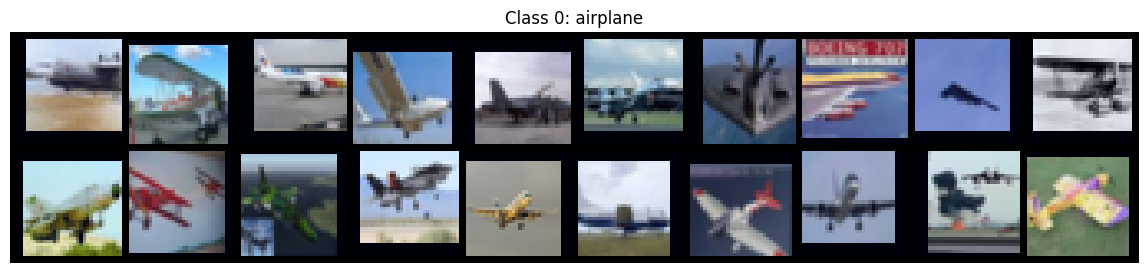

Class 1: automobile - 20 images


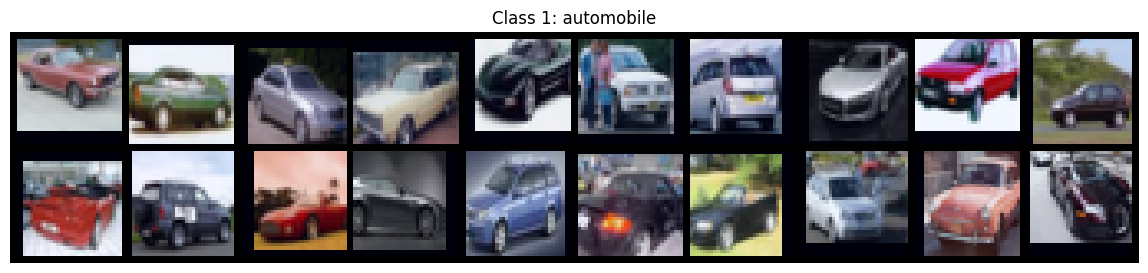

Class 2: bird - 20 images


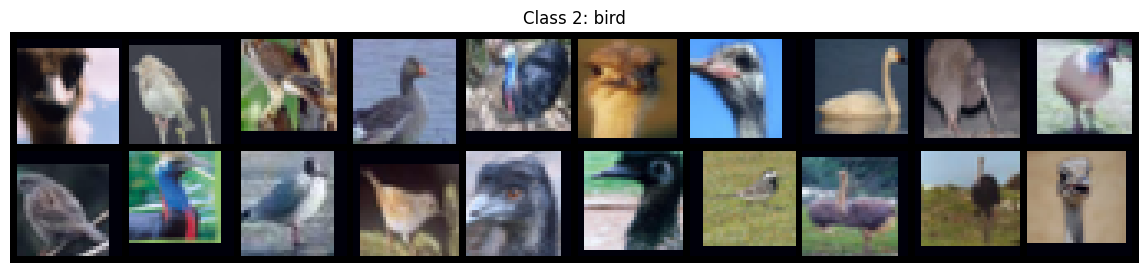

Class 3: cat - 20 images


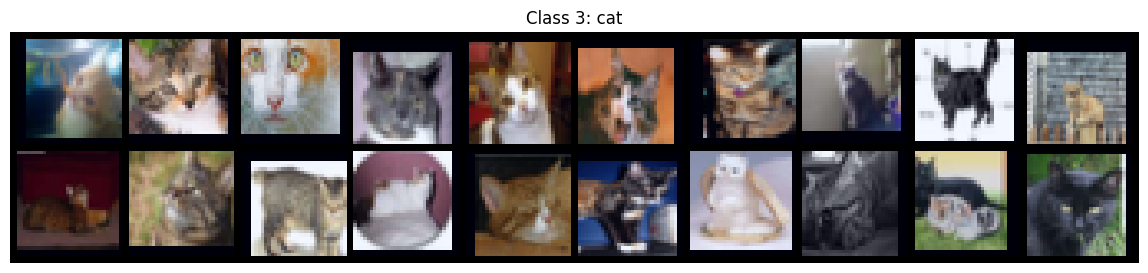

Class 4: deer - 20 images


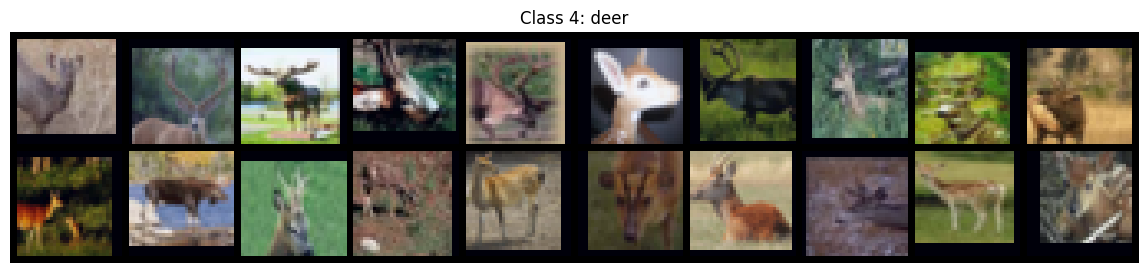

Class 5: dog - 20 images


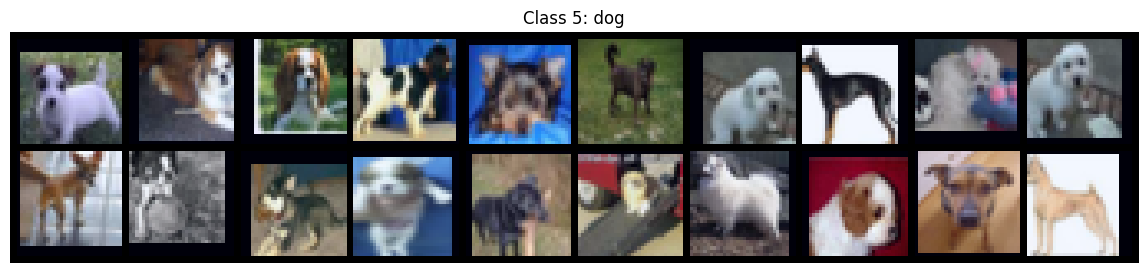

Class 6: frog - 20 images


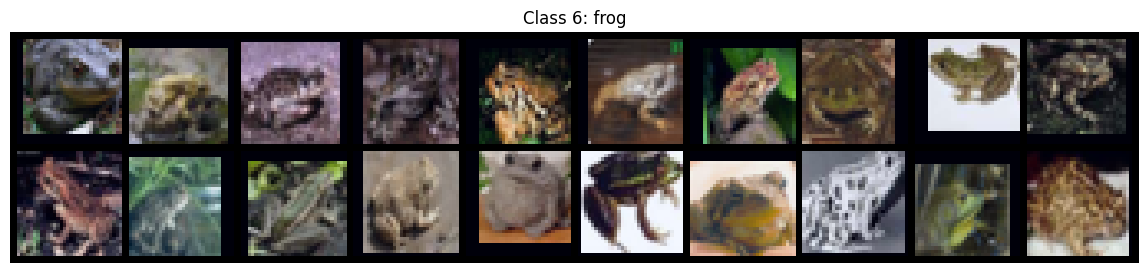

Class 7: horse - 20 images


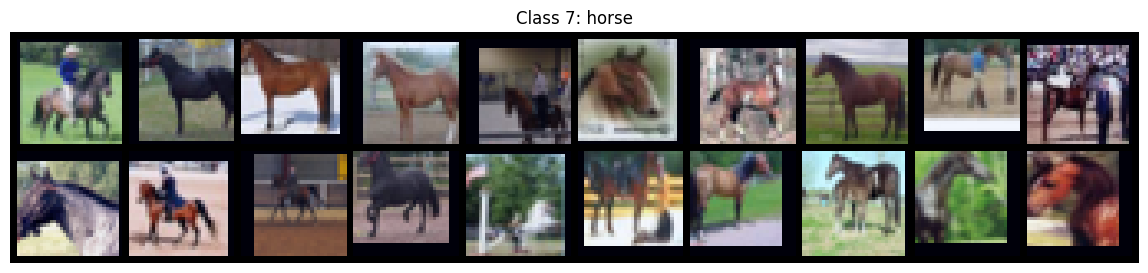

Class 8: ship - 20 images


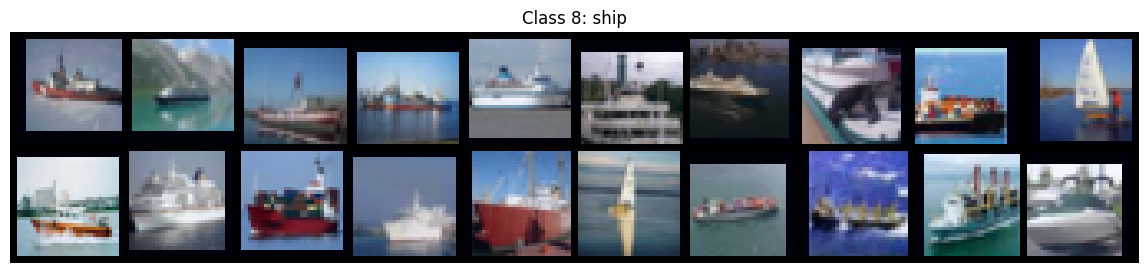

Class 9: truck - 20 images


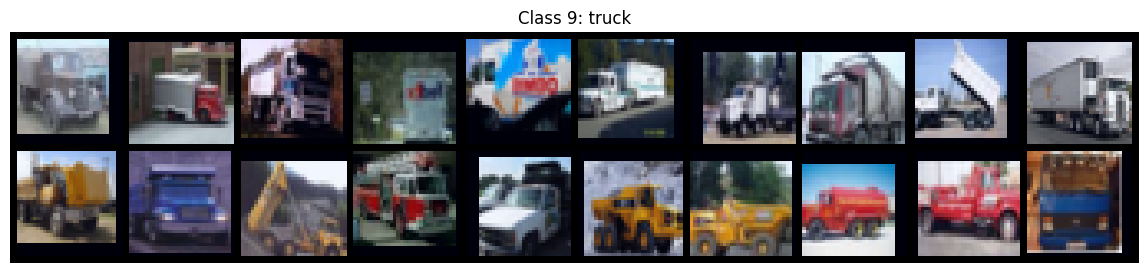

In [ ]:
# Visualizing the example subset
import matplotlib.pyplot as plt
import torchvision
import torch

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

indices = get_balanced_split(trainset, per_class_size=20, num_classes=10)
subset = torch.utils.data.Subset(trainset, indices)
loader = torch.utils.data.DataLoader(subset, batch_size=len(subset))

dataiter = iter(loader)
images, _, _, labels = next(dataiter)

for class_idx in range(10):
    class_images = images[labels == class_idx]
    print(f"Class {class_idx}: {classes[class_idx]} - {len(class_images)} images")

    grid_img = torchvision.utils.make_grid(class_images, nrow=10, normalize=True, padding=2)
    plt.figure(figsize=(15, 3))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.title(f"Class {class_idx}: {classes[class_idx]}")
    plt.axis('off')
    plt.show()

### Semi-superviced settings: Fine-Tuned RotNet

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

per_class_counts = [20, 100, 400, 1000, 5000]
rotnet_acc = {}

for size in per_class_counts:
    print(f"\n--- Training with per class size: {size} ---")

    # Reload the pre-trained RotNet model
    net4 = resnet18(num_classes=4)
    net4.load_state_dict(torch.load('./cifar_rotation_net.pth'))
    net4.fc = nn.Linear(net4.fc.in_features, 10)
    net4 = net4.to(device)

    # Freeze all but layer4 and fc
    for name, param in net4.named_parameters():
        if not name.startswith('layer4') and not name.startswith('fc'):
            param.requires_grad = False

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net4.parameters())

    # Generate balanced subset
    indices = get_balanced_split(trainset, size)
    subset = Subset(trainset, indices)
    subset_loader = torch.utils.data.DataLoader(subset, batch_size=128, shuffle=True, num_workers=2)

    # Train and evaluate
    accuracy = train(net4, criterion, optimizer, num_epochs=30, decay_epochs=10, init_lr=0.01,
                     task='classification', trainloader=subset_loader, testloader=testloader)

    rotnet_acc[size] = accuracy
    print(f"Finished training on {size} per class samples. Test Accuracy: {accuracy:.2f}%")


--- Training with per class size: 20 ---
TESTING:
Accuracy of the network on the 10000 test images: 11.36 %
Average loss on the 10000 test images: 2.237
TESTING:
Accuracy of the network on the 10000 test images: 14.44 %
Average loss on the 10000 test images: 2.199
TESTING:
Accuracy of the network on the 10000 test images: 16.76 %
Average loss on the 10000 test images: 2.175
TESTING:
Accuracy of the network on the 10000 test images: 18.36 %
Average loss on the 10000 test images: 2.157
TESTING:
Accuracy of the network on the 10000 test images: 20.00 %
Average loss on the 10000 test images: 2.130
TESTING:
Accuracy of the network on the 10000 test images: 21.64 %
Average loss on the 10000 test images: 2.103
TESTING:
Accuracy of the network on the 10000 test images: 21.75 %
Average loss on the 10000 test images: 2.079
TESTING:
Accuracy of the network on the 10000 test images: 21.91 %
Average loss on the 10000 test images: 2.060
TESTING:
Accuracy of the network on the 10000 test images: 24.

### Supervised (from 3.2)

In [ ]:
per_class_counts = [20, 100, 400, 1000, 5000]
supervised_acc = {}

for size in per_class_counts:
    print(f"\n--- Training with per class size: {size} ---")

    # Initialize random ResNet18
    net = resnet18(num_classes=10)
    net = net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())

    # Generate balanced subset
    indices = get_balanced_split(trainset, size)
    subset = Subset(trainset, indices)
    subset_loader = torch.utils.data.DataLoader(subset, batch_size=128, shuffle=True, num_workers=2)

    # Train and evaluate
    accuracy = train(net, criterion, optimizer, num_epochs=30, decay_epochs=10, init_lr=0.01,
                     task='classification', trainloader=subset_loader, testloader=testloader)

    supervised_acc[size] = accuracy
    print(f"Finished training on {size} per class samples. Test Accuracy: {accuracy:.2f}%")


--- Training with per class size: 20 ---
TESTING:
Accuracy of the network on the 10000 test images: 10.00 %
Average loss on the 10000 test images: 118820.492
TESTING:
Accuracy of the network on the 10000 test images: 10.00 %
Average loss on the 10000 test images: 737333.000
TESTING:
Accuracy of the network on the 10000 test images: 10.00 %
Average loss on the 10000 test images: 146706.953
TESTING:
Accuracy of the network on the 10000 test images: 10.00 %
Average loss on the 10000 test images: 30800.238
TESTING:
Accuracy of the network on the 10000 test images: 10.00 %
Average loss on the 10000 test images: 10811.951
TESTING:
Accuracy of the network on the 10000 test images: 10.01 %
Average loss on the 10000 test images: 1565.927
TESTING:
Accuracy of the network on the 10000 test images: 10.07 %
Average loss on the 10000 test images: 237.080
TESTING:
Accuracy of the network on the 10000 test images: 10.30 %
Average loss on the 10000 test images: 94.043
TESTING:
Accuracy of the network 

### Recreated Figure 5b

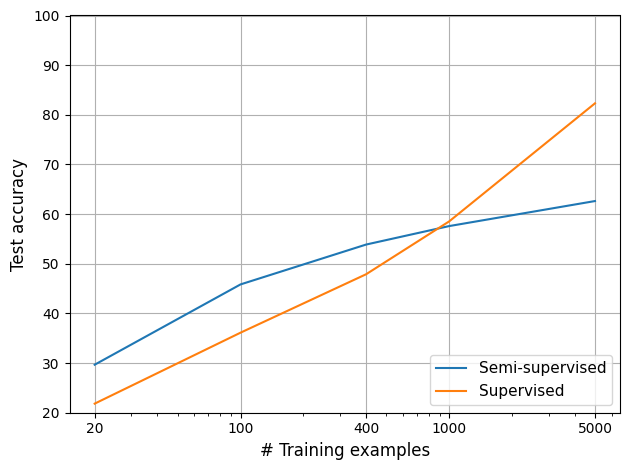

In [ ]:
per_class_counts = [20, 100, 400, 1000, 5000]

rotnet_values = [rotnet_acc[size] for size in per_class_counts]
supervised_values = [supervised_acc[size] for size in per_class_counts]

plt.plot(per_class_counts, rotnet_values, label='Semi-supervised')
plt.plot(per_class_counts, supervised_values, label='Supervised')

plt.xscale('log')
plt.xticks(x, labels=x)
plt.xlabel('# Training examples', fontsize=12)
plt.ylabel('Test accuracy', fontsize=12)
plt.ylim(20, 100)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True)
plt.tight_layout()
plt.show()